## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import numpy as np
import tensorflow as tf
import sentencepiece as spm
import re
import os
import random

import seaborn

## Data load

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    raw = zip(kor, eng)
    cleaned_corpus = set(raw)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [4]:
kor_corpus, eng_corpus = zip(*cleaned_corpus)
print(len(kor_corpus), len(eng_corpus))

78968 78968


## Preprocessing

In [5]:
def preprocess_sentence(sentence, k_token = False, e_token = False):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    if k_token:
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

        sentence = sentence.strip()
        
    if e_token:
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
    
    return sentence

In [6]:
enc_corpus = []
dec_corpus = []

for kor, eng in zip(kor_corpus, eng_corpus):
    temp_kor = preprocess_sentence(kor, k_token = True)
    temp_eng = preprocess_sentence(eng, e_token = True)

    enc_corpus.append(temp_kor)
    dec_corpus.append(temp_eng)
    
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[500])   
print("English:", dec_corpus[500]) 

korean data size: 78968
english data size: 78968
Korean: 아지즈 총리는 국가의 통치권은 보호될 것이며 어떤 외부의 간섭도 용납하지 않겠다 고 전했다 .
English: The integrity and sovereignty of the country will be protected at all cost and no outside interference will be allowed , Aziz said .


## Tokenization

In [7]:
#sentencepiece에 적용하기 위한 txt파일 생성

with open('kor.txt', 'w') as f:
    for sentence in kor_corpus:
        f.write('{}\n'.format(sentence))

In [8]:
with open('eng.txt', 'w') as f:
    for sentence in eng_corpus:
        f.write('{}\n'.format(sentence))

In [9]:
def generate_tokenizer(txt):
    templates= '--input={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --model_prefix={} \
    --vocab_size={} \
    --character_coverage={} \
    --model_type={}'
    
    train_input_file = txt
    vocab_size = 20000 # vocab 사이즈
    prefix = txt.split('.')[0] + '_spm' # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0 #<pad> token을 0으로 설정
    bos_id=1 #<BOS> token을 1으로 설정
    eos_id=2 #<EOS> token을 2으로 설정
    unk_id=3 #<UNK> token(unknown)을 3으로 설정
    character_coverage = 1.0 # to reduce character set
    model_type ='unigram' # Choose from unigram (default), bpe, char, or word

    cmd = templates.format(train_input_file,
                           pad_id,
                           bos_id,
                           eos_id,
                           unk_id,
                           prefix,
                           vocab_size,
                           character_coverage,
                           model_type)
    
    spm.SentencePieceTrainer.Train(cmd)
    sp = spm.SentencePieceProcessor()
    sp.Load(prefix + '.model')
    
    return sp

In [10]:
ko_tokenizer = generate_tokenizer('kor.txt')
en_tokenizer = generate_tokenizer('eng.txt')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=kor.txt     --pad_id=0     --bos_id=1     --eos_id=2     --unk_id=3     --model_prefix=kor_spm     --vocab_size=20000     --character_coverage=1.0     --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: kor.txt
  input_format: 
  model_prefix: kor_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
 

In [11]:
en_tokenizer.SetEncodeExtraOptions('bos:eos')

ainer.cc(505) LOG(INFO) EM sub_iter=0 size=35547 obj=13.8829 num_tokens=615670 num_tokens/piece=17.3199
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=35547 obj=13.8313 num_tokens=615738 num_tokens/piece=17.3218
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=26660 obj=14.1313 num_tokens=648768 num_tokens/piece=24.3349
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=26660 obj=14.0744 num_tokens=648789 num_tokens/piece=24.3357
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=22000 obj=14.3013 num_tokens=671614 num_tokens/piece=30.5279
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=22000 obj=14.2607 num_tokens=671657 num_tokens/piece=30.5299
trainer_interface.cc(615) LOG(INFO) Saving model: kor_spm.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: kor_spm.vocab
sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=eng.txt     --pad_id=0     --bos_id=1     --eos_id=2     --unk_id=3     --model_prefix=eng_spm     --v

True

In [12]:
src_train = []
tgt_train = []

for i in range(0, len(kor_corpus)):
    src_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[i])
    tgt_tokens = en_tokenizer.EncodeAsIds(eng_corpus[i])

    if (len(src_tokens) > 50): continue
    if (len(tgt_tokens) > 50): continue
    
    src_train.append(src_tokens)
    tgt_train.append(tgt_tokens) 

In [16]:
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_train, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_train, padding='post')

print(len(enc_train), len(dec_train))

print(enc_train.shape)
print(dec_train.shape)

71985 71985
(71985, 50)
(71985, 50)


In [17]:
print(enc_train[0])
print(dec_train[0])

[6856 4672   18 7564   47  356 2472  593 5480 5350  794    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[    1    17  1423  1516   161     4   812     9 11065     6    56    37
  1289    13     7  2000   856     9  3554     5     2     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [18]:
with open('./kor_spm.vocab', encoding='utf-8') as f:
    Vo_k = [doc.strip().split("\t") for doc in f]

kor_word2idx = {w[0]: i for i, w in enumerate(Vo_k)}

In [19]:
with open('./eng_spm.vocab', encoding='utf-8') as f:
    Vo_e = [doc.strip().split("\t") for doc in f]

eng_word2idx = {w[0]: i for i, w in enumerate(Vo_e)}

In [20]:
VOCAB_SIZE = len(kor_word2idx)

In [21]:
len(eng_word2idx)

20000

In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': enc_train,
        'dec_inputs': dec_train[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': dec_train[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 50), dec_inputs: (None, 49)}, {outputs: (None, 49)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

## Modeling - Transformer

In [25]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [26]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [28]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [33]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

## Training

In [34]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [35]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [36]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [37]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [38]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## Evaluation and visualization

In [39]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [40]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    
    sentence = preprocess_sentence(sentence, k_token= True)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [41]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [42]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [44]:
for sen in sentences:
    translate(sen, transformer, ko_tokenizer, en_tokenizer)

Input: 오바마는 대통령이다.
Predicted translation: top piracy resemble resemble transmission v chocolate plays tailor plays defendTuesdayTuesdayTuesday vribe plays acquir Tonight v Tonight plays Tonight v Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight plays minor grenadeTuesday Tonight Tonight Tonight Tonight Tonight Tonight Tonight
Input: 시민들은 도시 속에 산다.
Predicted translation: breach With With With With transmission Pixar transmission clouds interception defendTuesday RichmondTuesday RichmondTuesday Richmond Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight electric With Tonight Tonight Tonight Tonight Tonight Tonight Tonight Tonight
Input: 커피는 필요 없다.
Predicted translation: stitches stake Basilica dynamite dynamite dynamite dynamite dynamite dynamite dynamite dynamite dynamite dynamite dynam

In [45]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    if epoch < EPOCHS:
        for sen in sentences:
            translate(sen, transformer, ko_tokenizer, en_tokenizer)
    
    else:
        for sen in sentences:
            translate(sen, transformer, ko_tokenizer, en_tokenizer, plot_attention = True)

/tmp/ipykernel_576/1649253655.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: Obama Obama is expected to be the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: The man was the first time.
Input: 커피는 필요 없다.
Predicted translation: The couple is the first time.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: The death toll were killed in the attack.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: Obama is expected to be a third term.
Input: 시민들은 도시 속에 산다.
Predicted translation: The city of the city of the city.
Input: 커피는 필요 없다.
Predicted translation: coffee the coffee is a coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: The deaths were killed in the deaths of the deaths.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: Obama is a political challenge.
Input: 시민들은 도시 속에 산다.
Predicted translation: The city's city of Rio city.
Input: 커피는 필요 없다.
Predicted translation: coffee, it doesn't want to get coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: The seven deaths were killed in the attack.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: Obama was elected.
Input: 시민들은 도시 속에 산다.
Predicted translation: The city is the highest mountain mountain.
Input: 커피는 필요 없다.
Predicted translation: The won't be surprised.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: The seven seven died of seven dead.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: Obama has been President Barack Obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: The city is a city of San Siro, the city's San city is a city of Santo city.
Input: 커피는 필요 없다.
Predicted translation: The prize is required.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: The seven-member toll was the rise of seven.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: I expect President Barack Obama to be my office:
Input: 시민들은 도시 속에 산다.
Predicted translation: The city is a city township in towns with a mountain.
Input: 커피는 필요 없다.
Predicted translation: coffee bars
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: Seven seven deaths are dead, the report said.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: Obama can pick up.
Input: 시민들은 도시 속에 산다.
Predicted translation: city mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain mountain.
Input: 커피는 필요 없다.
Predicted translation: The no Buy.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: Seven of the dead were destroyed.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: I President Barack Obama on Thursday.
Input: 시민들은 도시 속에 산다.
Predicted translation: Many urban mountain do the city's mountain.
Input: 커피는 필요 없다.
Predicted translation: The won't get caught on drinking.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were among seven.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: I President Bush has a way.
Input: 시민들은 도시 속에 산다.
Predicted translation: The city mountain is a mountain guide.
Input: 커피는 필요 없다.
Predicted translation: The Praring of coffee neither need for
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven deaths were reported.


  0%|          | 0/1125 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: Obama is expected to be the first of ever.
Input: 시민들은 도시 속에 산다.
Predicted translation: They have a mountain youths cut in the city.
Input: 커피는 필요 없다.
Predicted translation: The schedule never need for coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: Seven seven out of seven are expected.


## Discussion

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.  
 - **데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.**  
 
 
2. Transformer 번역기 모델이 정상적으로 구동된다.  
 - **Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.**  
 
 
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.  
 - **제시된 문장에 대한 그럴듯한 영어 번역문이 생성되었다.**
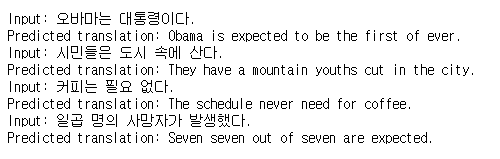

## Reference

1. https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-10%5Dtransformer_translation.ipynb
2. https://github.com/hongdune/aiffel/blob/master/GD10_Transformer.ipynb